#Predicting the next word as per Shakespeare Sonnets Dataset

Create a model that will predict the next word in a text sequence

Will implement the model and train it using a corpus of Shakespeare's sonnets.


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

Here we will be using the Shakespeare Sonnets Dataset, which contains more than 2000 lines of text extracted from Shakespeare's sonnets.


In [ ]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 84.1MB/s]


In [ ]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


##Tokenizing the text
Fit the Tokenizer to the corpus and save the total number of words.


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1


When converting the text into sequences we will use the texts_to_sequences.

We need to process this corpus one line at a time.

The first example of the corpus is a string and looks like this:



In [ ]:
[corpus[0]]


['from fairest creatures we desire increase,']

If we pass this text directly into the texts_to_sequences method we will get an unexpected result:

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

##Generating n_grams
**n_gram_seqs**: This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the n_gram sequences for each line in the corpus:



In [ ]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    corpus_len = len(corpus)

    for idx in range(corpus_len):
      tokens = tokenizer.texts_to_sequences([corpus[idx]])[0]
      tokensLen = len(tokens)
    
      for i in range(2, tokensLen+1):
        input_sequences.append(tokens[:i])

    return input_sequences


In [ ]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [ ]:
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

In [ ]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")


n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


##Add padding to the sequences
**pad_seqs**: Will pad any given sequences to the desired maximum length. 

In [ ]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen)
    
    return padded_sequences
    

In [ ]:
# Test our function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [ ]:
# Test our function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [ ]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


##Split the data into features and labels

Before feeding the data into the neural network we should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

**features_and_labels**: This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

Notice that the function also receives the total of words in the corpus, this parameter will be very important when one hot enconding the labels since every word in the corpus will be a label at least once. If you need a refresh of how the to_categorical function works take a look at the docs

In [ ]:
len(input_sequences[:,-1]), total_words

(15462, 3211)

In [ ]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """

    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    
    return features, one_hot_labels


In [ ]:
# Test our function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features


labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [ ]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


##Create the model
Now we define a model architecture capable of achieving an accuracy of at least 80%.

Some hints to help you in this task:

* An appropriate output_dim for the first layer (Embedding) is 100, this is already provided for you.
* A Bidirectional LSTM is helpful for this particular problem.
* The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.

This problem can be solved with only two layers (excluding the Embedding) so try out small architectures first.


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:

def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()

    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.01),
                  metrics=['accuracy'])

    return model


In [ ]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 26s 47ms/step - loss: 6.7918 - accuracy: 0.0329
Epoch 2/50
484/484 [==============================] - 22s 46ms/step - loss: 6.0894 - accuracy: 0.0578
Epoch 3/50
484/484 [==============================] - 23s 47ms/step - loss: 5.3858 - accuracy: 0.0834
Epoch 4/50
484/484 [==============================] - 23s 48ms/step - loss: 4.5952 - accuracy: 0.1335
Epoch 5/50
484/484 [==============================] - 23s 48ms/step - loss: 3.7534 - accuracy: 0.2293
Epoch 6/50
484/484 [==============================] - 24s 49ms/step - loss: 3.0368 - accuracy: 0.3344
Epoch 7/50
484/484 [==============================] - 24s 49ms/step - loss: 2.4899 - accuracy: 0.4373
Epoch 8/50
484/484 [==============================] - 23s 48ms/step - loss: 2.0806 - accuracy: 0.5194
Epoch 9/50
484/484 [==============================] - 23s 48ms/step - loss: 1.7627 - accuracy: 0.5809
Epoch 10/50
484/484 [==============================] - 24s 50ms/step - loss: 1.580

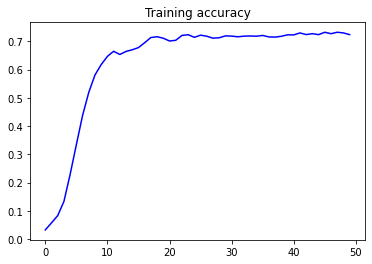

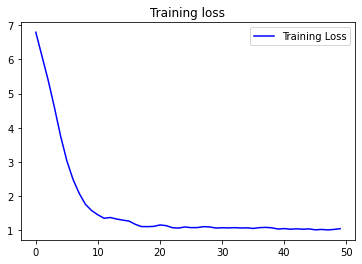

In [ ]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

##See the model in action
See our model generating text.

Run the cell below to generate the next 100 words of a seed text.


In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
  # Convert the text into sequences
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  # Pad the sequences
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # Get the probabilities of predicting a word
  predicted = model.predict(token_list, verbose=0)
   # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(predicted)[0][-choice]

  # Ignore if index is 0 because that is just the padding.
  if predicted != 0:
    # Look up the word associated with the index. 
    output_word = tokenizer.index_word[predicted]

    seed_text += " " + output_word

In [ ]:
# Print the result	
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope than that worth is growth 'no ' ' ' so ' place so ' sins 'will' will loathsome lie 'will' ' number me me still so ' ' ' thou tell true gain ' ' thee me ' untutor'd waste ' even ' ' well thee one ' add thee ' due live we before ' ' due in thee me thou ' ending hideous 'will' love latch reproving 'will' more give me welcome both me now thence me you me me ' ' so bold 'will heat still ' time one me ' untutor'd me me hence what's are
